In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
series_tconst = 'tt0149460' # Futurama

### read database and select all Futurama episodes

In [3]:
df = pd.read_csv('title.episode.tsv', sep='\t')
series_df = df[df['parentTconst'].str.contains(series_tconst)] # Futurama = tt0149460
del df

### cleanup of dataframe

In [4]:
series_df[['seasonNumber','episodeNumber']] = series_df[['seasonNumber','episodeNumber']].astype(int)
series_df = series_df.drop_duplicates(subset=['seasonNumber','episodeNumber'])
series_df = series_df.sort_values(['seasonNumber', 'episodeNumber'])
series_df = series_df.set_index(np.arange(series_df.shape[0]))
# series_df

In [5]:
def add_to_df(filename, colname, dtype=None):
    if type(colname) != list:
        colname = [colname]
    for cname in colname:
        new_df = pd.read_csv(filename, sep='\t', usecols=colname)
        values = [new_df[new_df['tconst'] == tc][cname].iloc[0]
                  for tc in series_df['tconst']]
        new_series = pd.Series(values, index=series_df.index, dtype=dtype)
        series_df[cname] = new_series
    
    del new_df
    return None

### add interesting information from other data files

In [6]:
add_to_df('title.ratings.tsv', ['averageRating', 'numVotes'], dtype=float)

In [7]:
add_to_df('title.basics.tsv', ['runtimeMinutes', 'startYear'], dtype=int)

/home/rgutzen/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/home/rgutzen/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/numeric.py:2591: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [8]:
add_to_df('title.crew.tsv', ['directors', 'writers'])

### select the n best episodes

In [9]:
nbr_of_episodes = 22
# manually add second episode
series_df.iloc[1,4] = series_df.iloc[0,4]
selected_episodes = series_df.nlargest(nbr_of_episodes, 'averageRating')
selected_episodes = selected_episodes.sort_values(['seasonNumber', 'episodeNumber'])

min_rating = selected_episodes.min()['averageRating']

print('Runtime: {:.2f} h'.format(selected_episodes.sum()['runtimeMinutes']/60))
selected_episodes[['seasonNumber', 'episodeNumber', 'averageRating']].to_csv('selected_episodes.csv')

Runtime: 9.88 h


### visualize the rating distribution

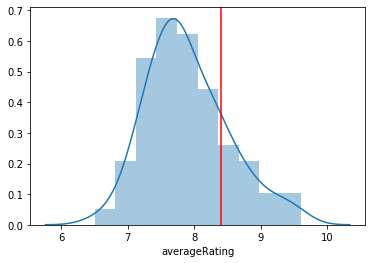

In [18]:
ax = sns.distplot(series_df['averageRating'])
ax.axvline(min_rating, color='r')
plt.savefig('rating_distribution.png')

### visualize the development of episode quality

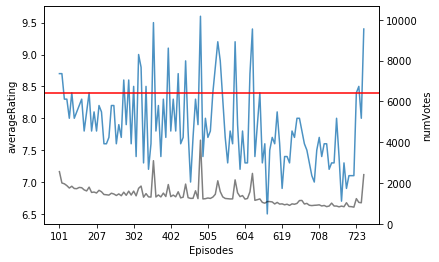

In [19]:
ax = sns.lineplot(data=series_df, x=series_df.index, y='averageRating', alpha=0.8)
ax2 = ax.twinx()
sns.lineplot(data=series_df, x=series_df.index, y='numVotes', ax=ax2, alpha=0.5, color='k')
ax2.set_ylim((0,ax2.get_ylim()[1]*2.5))

episode_names = [s*100+e for s,e in zip(series_df['seasonNumber'].array, series_df['episodeNumber'].array)]
ax.set_xticks(series_df.index[::15])
ax.set_xticklabels(episode_names[::15])
ax.set_xlabel('Episodes')
ax.axhline(min_rating, color='r')
plt.savefig('rating_over_time.png')

### visualize the many cooks question

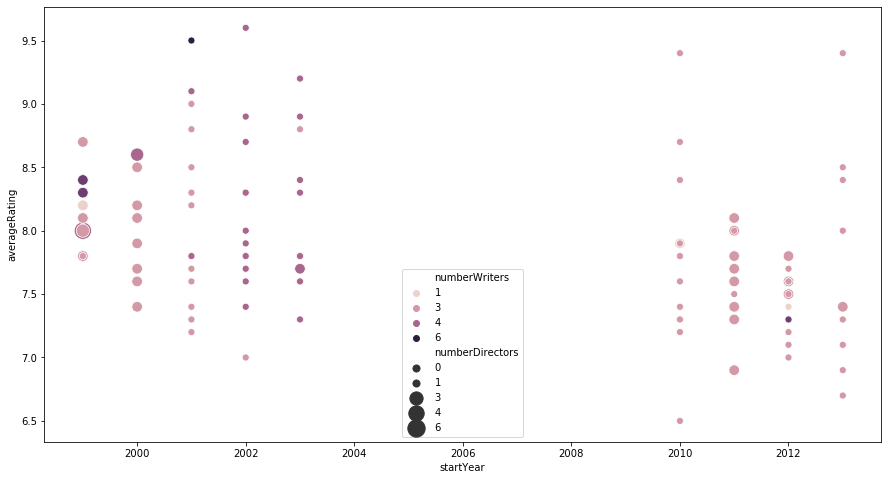

In [20]:
series_df['numberWriters'] = series_df['writers'].apply(lambda x: int((len(x)+1)/10))
series_df['numberDirectors'] = series_df['directors'].apply(lambda x: int((len(x)+1)/10))

fig, ax = plt.subplots(figsize=(15,8))
sns.scatterplot(x="startYear", y="averageRating",
                hue="numberWriters", size="numberDirectors",
                sizes=(50, 300),
                data=series_df,
                ax=ax)
plt.savefig('many_cooks.png')

### read cast information

In [13]:
df = pd.read_csv('title.principals.tsv', sep='\t', usecols=['tconst', 'characters'])
cast_df = df[df.tconst.isin(series_df['tconst'].array)]
del df

In [14]:
character_df = pd.DataFrame(columns=['character', 'tconst', 'averageRating'])

for i, (tconst, characters) in enumerate(zip(cast_df.tconst.array, 
                                             cast_df.characters.array)):
    if characters != '\\N':
        
        characters = characters[1:-1].replace('"','').split(',')
        avg_rating = series_df[series_df['tconst'] == tconst]['averageRating'].iloc[0]

        for character in characters:
            
            character_df = character_df.append({'character':character, 
                                                'tconst':tconst, 
                                                'averageRating':avg_rating},
                                                ignore_index=True)

In [15]:
character_counts = character_df['character'].value_counts().to_dict()
values = [character_counts[c] for c in character_df.character]
character_df['appearences'] = pd.Series(values, index=character_df.index, dtype=int)
character_df = character_df.sort_values(['appearences'], ascending=False)

### which characters are indicators for a good episode

In [16]:
character_df[character_df['character']=='Amy Wong']

,character,tconst,averageRating,appearences
453,Amy Wong,tt0756885,8.3,2
462,Amy Wong,tt0756886,7.8,2


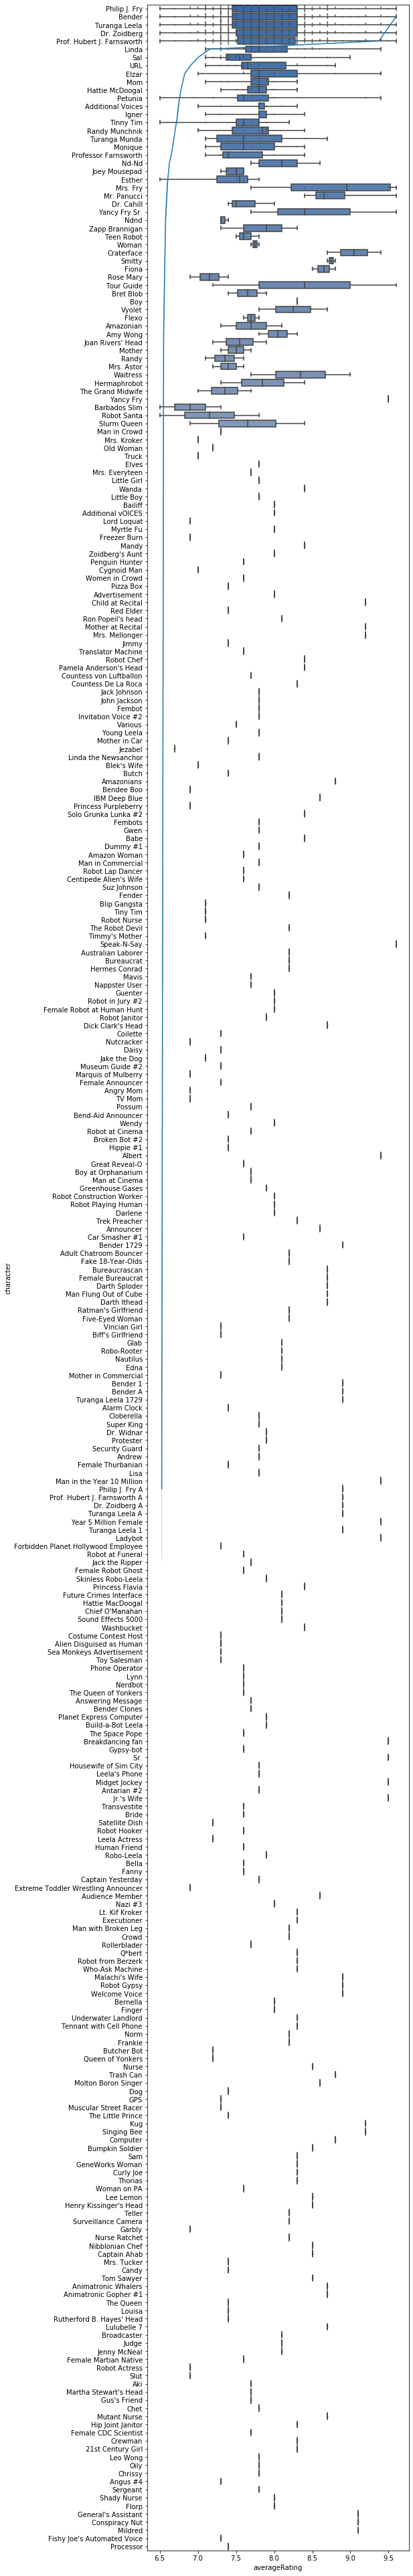

In [21]:
fig, ax = plt.subplots(figsize=(7, 70))

# Plot the orbital period with horizontal boxes
sns.boxplot(x="averageRating", y="character", data=character_df,
            whis="range", palette="vlag")

# Add in points to show each observation
sns.swarmplot(x="averageRating", y="character", data=character_df,
              size=2, color=".3", linewidth=0)

appearances = [v for v in character_counts.values()]
appearances /= np.max(appearances)
appearances *= (character_df.max()['averageRating']-character_df.min()['averageRating'])
appearances += character_df.min()['averageRating']

sns.lineplot(x=appearances, y=np.arange(len(character_counts)))
plt.savefig('character_appearances.png')